<a href="https://colab.research.google.com/github/Komsomolochka/open_data_battle_2021/blob/main/airport/airport.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install fbprophet

In [94]:
import pandas as pd
import datetime as dt
import fbprophet as fp
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns 
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from scipy import stats
from itertools import product
import warnings
import numpy as np

In [23]:
data = pd.read_csv('/content/Science.csv')

In [28]:
data.head()

,Passengers,Year,Month
0,1235.75,2007,4
1,1487.53,2007,3
2,1563.96,2007,7
3,1575.27,2007,0
4,1762.00,2007,8


Подготовим данные

In [29]:
data['Month'] = data['Month'] + 1

In [30]:
data['ds'] = (data[['Year', 'Month']].apply(lambda x: dt.date(x.Year, x.Month, 1), axis=1))

In [31]:
data = (data.rename(columns={'Passengers': 'y'}).filter(items=['ds', 'y']).sort_values('ds', ascending=True))

In [6]:
data.head()

,ds,y
3,2007-01-01,1575.27
7,2007-02-01,1956.15
11,2007-03-01,2365.56
1,2007-04-01,1487.53
0,2007-05-01,1235.75


In [36]:
target = data[data['y'].isna()]
train = data[(~data['y'].isna()) & (data['ds'].apply(lambda x: x.year not in [2018,2019]))]
test = data[(~data['y'].isna()) & (data['ds'].apply(lambda x: x.year == 2018))]

Обучаем модель

In [10]:
fp_model = fp.Prophet()
fp_model.fit(train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [11]:
y_pred = fp_model.predict(test[['ds']])[['ds', 'yhat']]
mean_squared_error(test.y, y_pred.yhat)

909994.8500970788

Попробуем построить временную модель

In [39]:
train = train.set_index('ds')

In [40]:
train = train.asfreq('MS')

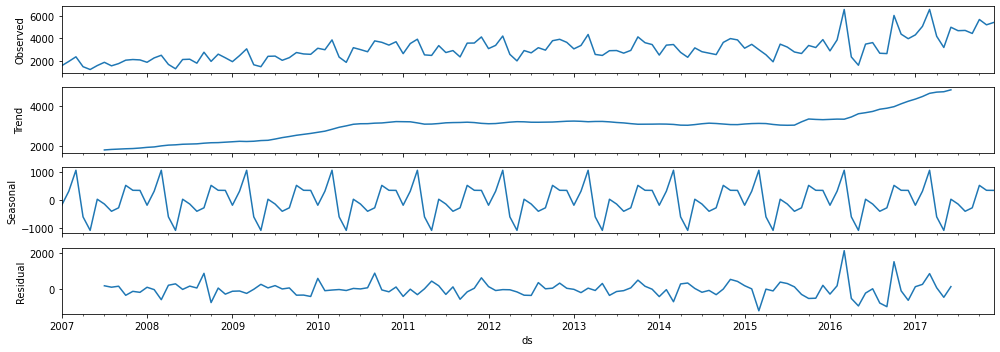

Критерий Дики-Фуллера: p=0.994727


In [41]:
plt.rc("figure",figsize=(14,5))
decomp_viz = sm.tsa.seasonal_decompose(train)
decomp_viz.plot()
plt.show()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(train['y'])[1])

Избавляемся от сезонности и тренда и помощью дифференцирования и преобразования Бокса-Кокса

Оптимальный параметр преобразования Бокса-Кокса: 0.071634
Критерий Дики-Фуллера: p=0.994727


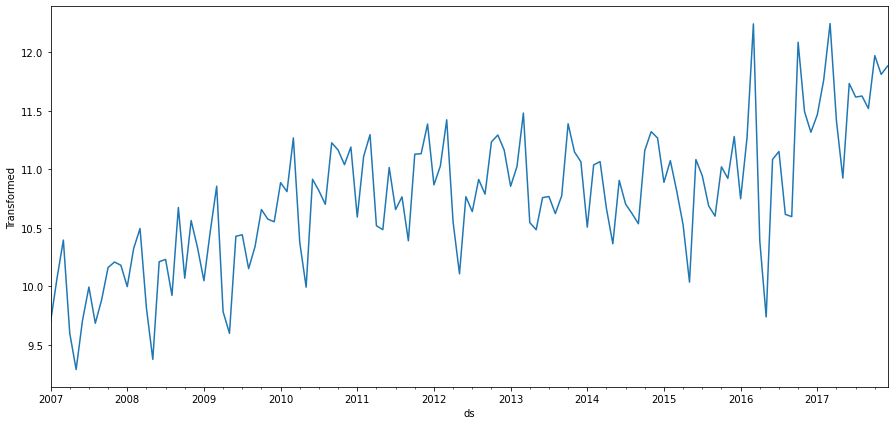

In [42]:
train['y_box'], lmbda = stats.boxcox(train['y'])
plt.rc("figure",figsize=(15,7))
train['y_box'].plot()
plt.ylabel(u'Transformed')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(train['y'])[1])

Критерий Дики-Фуллера: p=0.135007


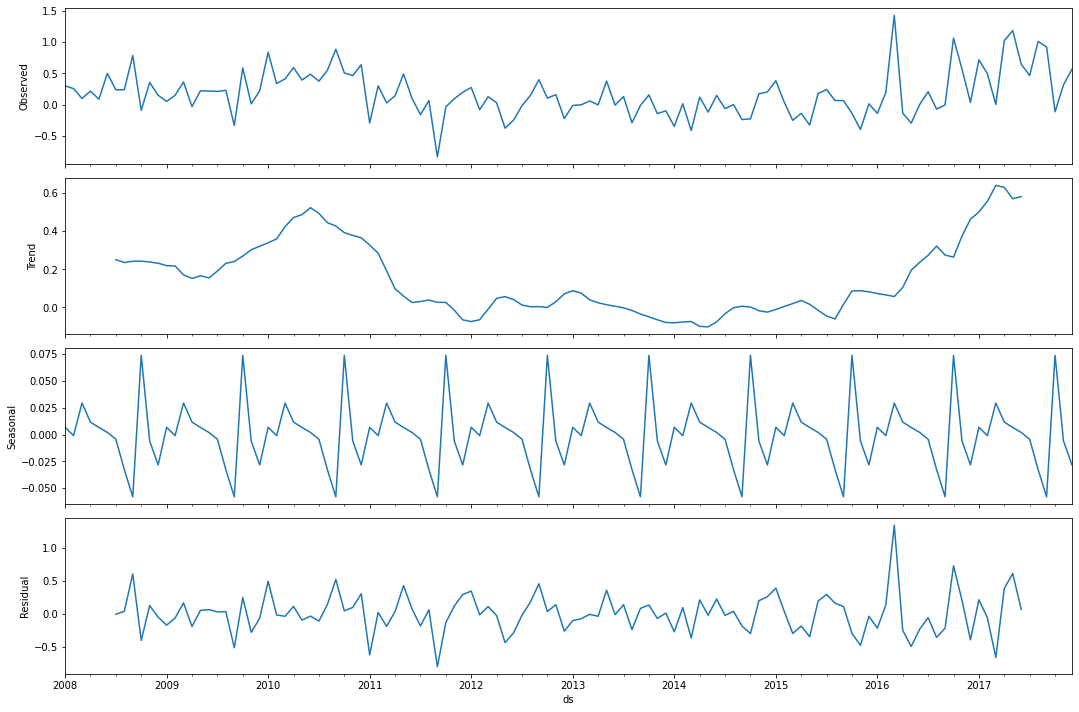

In [43]:
train['y_diff'] = train['y_box'] - train['y_box'].shift(12)
plt.rc("figure",figsize=(15,10))
sm.tsa.seasonal_decompose(train['y_diff'][12:], freq=12).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(train['y_diff'][12:])[1])

Критерий Дики-Фуллера: p=0.016114


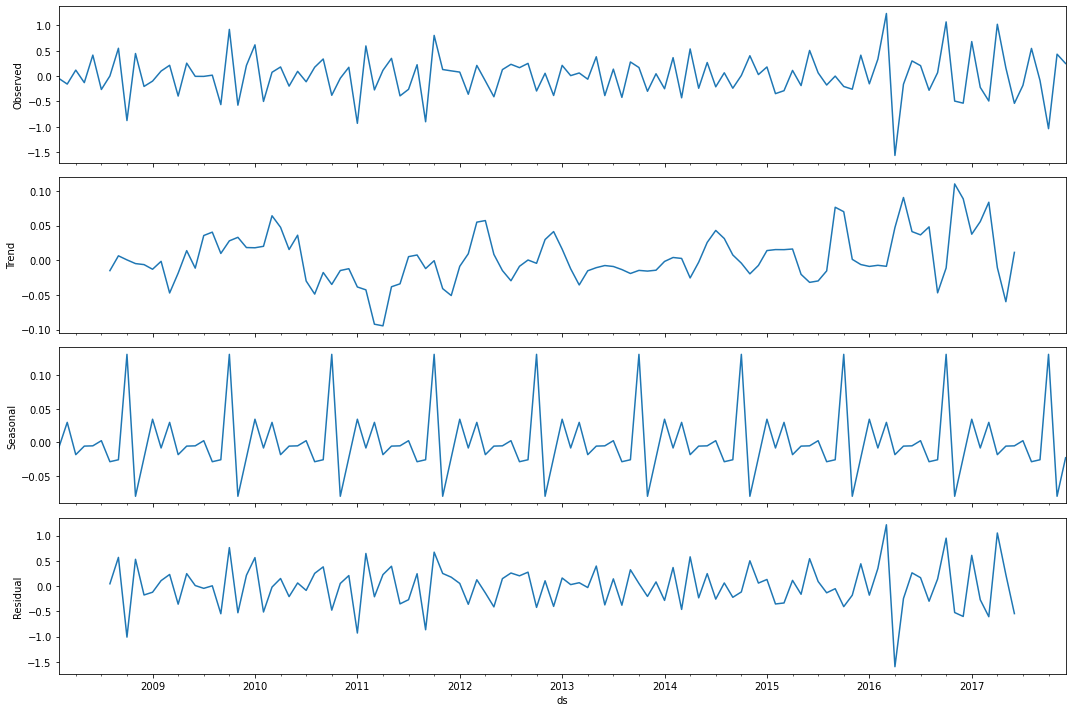

In [44]:
train['y_diff2'] = train['y_diff'] - train['y_diff'].shift(1)
plt.rc("figure",figsize=(15,10))
sm.tsa.seasonal_decompose(train['y_diff2'][13:], freq=12).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(train['y_diff2'][13:])[1])

Строим графики ACF и PACF, выбираем коэффициенты

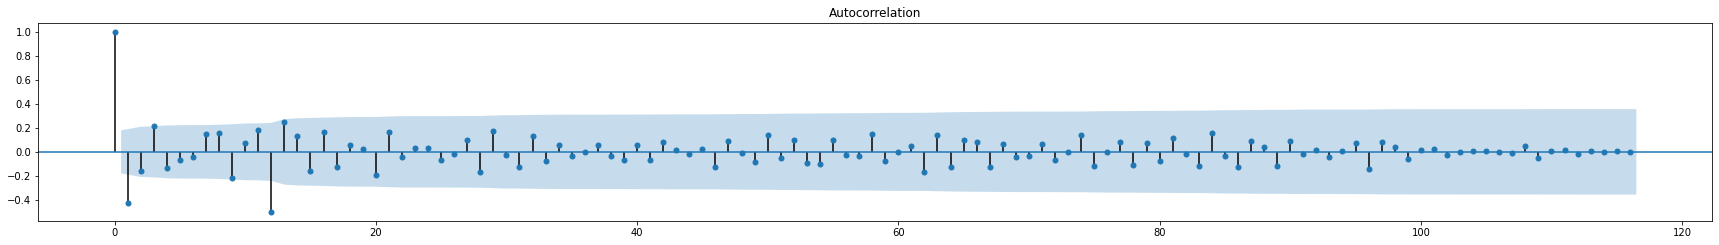

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


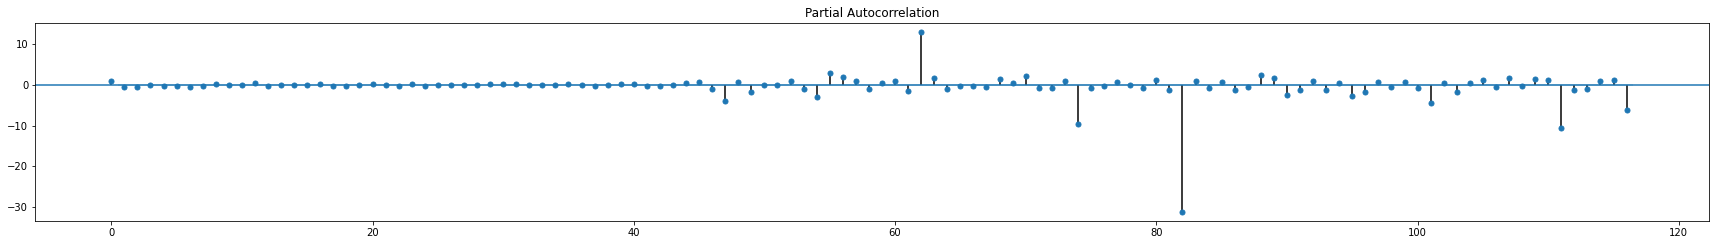

In [54]:
plt.rc("figure",figsize=(30,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(train['y_diff2'][13:].values.squeeze(), lags=116, ax=ax)
plt.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(train['y_diff2'][13:].values.squeeze(), lags=116, ax=ax)
plt.show()

In [55]:
ps = range(0, 1)
d=1
qs = range(0, 1)
Ps = range(0, 9)
D=2
Qs = range(0, 1)

In [56]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

9

In [58]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(train['y_box'], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

CPU times: user 3min 13s, sys: 1min 12s, total: 4min 26s
Wall time: 2min 40s


In [59]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

     parameters         aic
8  (0, 0, 8, 0)  120.054449
6  (0, 0, 6, 0)  125.978954
7  (0, 0, 7, 0)  127.336157
4  (0, 0, 4, 0)  134.883872
5  (0, 0, 5, 0)  136.774491


In [60]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              y_box   No. Observations:                  132
Model:             SARIMAX(0, 1, 0)x(8, 2, 0, 12)   Log Likelihood                 -51.027
Date:                            Tue, 15 Feb 2022   AIC                            120.054
Time:                                    11:25:49   BIC                            144.110
Sample:                                01-01-2007   HQIC                           129.806
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -1.7540      0.132    -13.304      0.000      -2.012      -1.496
ar.S.L24      -2.4176      0.218   

In [104]:
train

,y,y_box,y_diff,y_diff2
ds,,,,
2007-01-01,1575.27,9.695010,NaN,NaN
2007-02-01,1956.15,10.064817,NaN,NaN
2007-03-01,2365.56,10.394104,NaN,NaN
2007-04-01,1487.53,9.598098,NaN,NaN
2007-05-01,1235.75,9.287229,NaN,NaN
...,...,...,...,...
2017-08-01,4710.98,11.626056,1.011897,0.546212
2017-09-01,4442.73,11.518828,0.924423,-0.087474
2017-10-01,5681.38,11.971654,-0.114248,-1.038671


Проверяем остатки

In [93]:
print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Критерий Стьюдента: p=0.709803
Критерий Дики-Фуллера: p=0.000000


Делаем предсказания с помощью лучшей модели

In [106]:
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

In [113]:
pred = invboxcox(best_model.predict(start=132, end=143), lmbda)

In [114]:
mean_squared_error(test.y, pred)

1667131.9775118586

Ошибка предсказания Prorhet ниже, используем для дальнейших предсказаний

In [ ]:
fp_model = fp.Prophet()
fp_model.fit(pd.concat([train, test], ignore_index=True))
prediction = model.predict(target[['ds']])[['ds', 'yhat']]